# Исследование объявлений о продаже квартир

В распоряжении исследователя имеются данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

Осуществляется загрузка необходимых библиотек.

In [1]:
import pandas as pd #загружаем библиотеку pandas
import matplotlib as plt #загружаем библиотеку matplotlib

Осуществляется загрузка файла и первичное знакомство с данными.

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #считываем csv-файл, используя соответствующий разделитель

pd.set_option('display.max_columns', 50) #настраиваем максимальное число столбцов

data.info() #смотрим сводку основной информации
data.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Сразу же следует отметить, что некоторые заголовки записаны в разном регистре, в связи с чем вносятся необходимые корректировки.  

In [3]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 'parks_around3000': 'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'}) #меняем названия столбцов с корректировкой регистра

Другие особенности данных (пропуски, нетипичные значения) требуют более пристального рассмотрения.

### Вывод

В достаточно большом количестве столбцов имеются пропущенные значения - это может быть вызвано как ошибками ручного ввода, так и проблемами с автоматическим заполнением, учитывая различные виды источников данных. В дальнейших разделах исследования такие столбцы будут изучены отдельно. Также по итогам заполнения пропусков, вероятно, будет произведена замена типа данных в некоторых столбцах.

## Предобработка данных

Далее будут рассмотрены столбцы с пропусками.

Для столбца ceiling_height представляется допустимой замена пропусков на медианное значение.

In [4]:
ceiling_height_median = data['ceiling_height'].median() #рассчитываем медианное значение ceiling_height

data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median) #заменяем пропуски в столбце ceiling_height на медианное значение

Использование медианы, рассчитанной по всему массиву данных, в данном случае может быть уместным, так как высота потолков в явном виде не связана с другими количественными параметрами или категориальными характеристиками квартир.

Иначе обстоит дело с пропусками в значениях жилой площади и площади кухни. Они каким-то образом, очевидно, связаны с общей площадью квартиры. Поэтому для их корректного заполнения предлагается сначала рассчитать отношения соответствующих медианных значений.

In [5]:
living_area_median = data['living_area'].median() #рассчитываем медианное значение living_area
kitchen_area_median = data['kitchen_area'].median() #рассчитываем медианное значение kitchen_area
total_area_median = data['total_area'].median() #рассчитываем медианное значение total_area

living_ratio_median = living_area_median/total_area_median #определяем медианное отношение жилой площади к общей площади
kitchen_ratio_median = kitchen_area_median/total_area_median #определяем медианное отношение площади кухни к общей площади

data['living_area'] = data['living_area'].fillna(data['total_area']*living_ratio_median) #заменяем пропуски в столбце living_area с учетом медианного отношения к общей площади
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*kitchen_ratio_median) #заменяем пропуски в столбце kitchen_area с учетом медианного отношения к общей площади

Подобная логика заполнения пропусков позволит избежать случаев, когда жилая или кухонная площадь является непропорционально большой или малой относительно общей площади квартиры. 

Нетипичные значения могут появиться и в столбце floors_total, если заполнять их без привязки к столбцу floor. Однако логика такой привязки вряд ли может быть описана пропорцией, поэтому на данном этапе в столбце floors_total остаются пропуски.

Для столбца balcony можно принять более простую логику - отсутствие значения, скорее всего, означает отсутствие балкона.

In [6]:
data['balcony'] = data['balcony'].fillna(0) #заменяем пропуски в столбце balcony на ноль

Аналогичное предположение можно было бы сделать и относительно столбца is_apartment, то есть заполнить пропуски на значение false, но с учетом крайне большого числа подобных пропусков к данному параметру следует относиться осторожнее (возможно, такая статистика велась только по части базы данных или есть иное объяснение отсутствия информации). В связи с этим предлагается оставить пропуска незаполненными и вернуться к ним, если такая потребность возникнет в ходе дальнейшего анализа.   

Пропуска в различных гео-данных (расстояния и количества тех или иных объектов в радиусе) также характеризуются определенными закономерностями - в большинстве случаев количество заполненных записей составляет около 18100+ единиц. С учетом того, что часть данных заполняется автоматически, можно предположить, что объекты с пропусками просто не были охвачены действующей гео-информационной системой. Заполнять пропуска какими-то типичными значениями в этом случае не очень корректно, так как отсутствующие гео-данные могли обладать определенными особенностями (например, это окраины, имеющие больше выходов к паркам/прудам), препятствующими простому использованию медианных или средних значений.   

Пропуски в days_exposition могут быть связаны с тем, что квартира еще не снята с продажи, и также могут быть сохранены в датафрейме на данном этапе исследования.

Для столбцов с заполненными пропусками явно требуется изменить тип данных в столбце balcony на целочисленный, так как количество балконов не может быть дробным. Также разумно сразу перевести значения столбца first_day_exposition в формат даты.

In [7]:
data['balcony'] = data['balcony'].astype('int') #заменяем тип данных на int в столбце balcony
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #переводим данные в формат даты в столбце first_day_exposition

Для ряда оставшихся столбцов смена типа данных на целочисленный (там, где это было бы рационально) не представляется возможной на данном этапе в связи с сохранившимися пропусками.

Проводится проверка внесенных изменений.

In [8]:
data.info() #смотрим сводку основной информации
data.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,False,False,25.000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,False,False,11.000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,False,False,8.300,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,91.730769,9,NaN,False,False,27.825,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,False,False,41.000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Столбцы, в которых проводилась замена пропусков, являются заполненными, а типы столбцов были корректно изменены.

### Вывод

В таблице присутствуют как легко объяснимые, так и трудно объяснимые пропуски. Для относительно понятных с точки зрения заполнения параметров была произведена замена пропусков на медианные значения (или производные от них), либо константы. Часть же пропусков разумнее было оставить незаполненными, особенно в части гео-данных. Для тех столбцов, где это было возможно и рационально, была также произведена замена типов данных на наиболее подходящие.

## Расчёты и добавление результатов в таблицу

Далее проводится ряд дополнительных расчетов.

Рассчитывается цена квадратного метра.

In [9]:
data['meter_price'] = data['last_price']/data['total_area'] #добавляем столбец с результатом деления цены на общую площадь квартиры

Выделяются данные с днем недели, месяцем и годом публикации объявления.

In [10]:
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday #добавляем столбец с днем недели публикации объявления
data['exposition_month'] = data['first_day_exposition'].dt.month #добавляем столбец с месяцем публикации объявления
data['exposition_year'] = data['first_day_exposition'].dt.year #добавляем столбец с годом публикации объявления

Для определения категорий этажа квартиры создается специальная функция.

In [11]:
def floor_category(row): #функция возвращает категорию на основе сравнения текущего и максимального этажа
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

Функция применяется ко всем строкам датафрейма.

In [12]:
data['floor_category'] = data.apply(floor_category, axis=1) #добавляем столбец с результатами работы функции floor_category

Рассчитывается соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [13]:
data['living_ratio'] = data['living_area']/data['total_area'] #добавляем столбец с результатом деления жилой площади на общую площадь квартиры
data['kitchen_ratio'] = data['kitchen_area']/data['total_area'] #добавляем столбец с результатом деления площади кухни на общую площадь квартиры

Проводится проверка внесенных изменений.

In [14]:
data.info() #смотрим сводку основной информации
data.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,exposition_weekday,exposition_month,exposition_year,floor_category,living_ratio,kitchen_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,False,False,25.000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,False,False,11.000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,False,False,8.300,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,91.730769,9,NaN,False,False,27.825,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,0.576923,0.175000
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,False,False,41.000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000


Новые столбцы с расчетами успешно добавлены в таблицу.

### Вывод

Для дальнейшего анализа в таблицу был добавлен ряд расчетных значений. Особенно полезной в анализе может оказаться информация о цене за квадратный метр. Тот факт, что расчеты прошли без ошибок, а новые столбцы полностью заполнены значениями, говорит о достаточной полноте проведенной ранее работы по устранению пропусков в данных.

## Исследовательский анализ данных

Далее проводится более подробный анализ некоторых параметров.

Применяется описание значений и построение первичной гистограммы для параметра total_area.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


<AxesSubplot:>

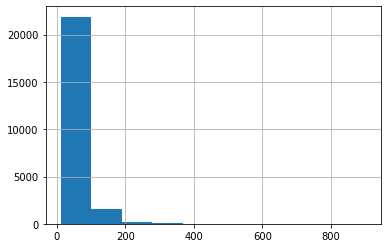

In [15]:
print(data['total_area'].describe()) #смотрим описание значений в столбце total_area
data['total_area'].hist() #строим гистограмму для столбца total_area

Отмечается крайне высокое максимальное значение параметра общей площади - 900 м2, а также достаточно низкое минимальное значение - 12 м2. При этом первичная гистограмма показывает, что подавляющее большинство квартир имеют площадь до 250 м2.

Построим новую гистограмму total_area, ограничив диапазон значений и увеличив число "корзин".

<AxesSubplot:>

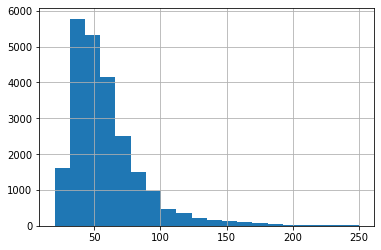

In [16]:
data['total_area'].hist(bins=20, range=(20, 250)) #строим гистограмму для столбца total_area по уточненным параметрам

Новая гистограмма total_area выглядит гораздое более реалистичной. В дальнейшем предполагается ориентироваться на выбранные значения.

Применяется описание значений и построение первичной гистограммы для параметра last_price.

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


<AxesSubplot:>

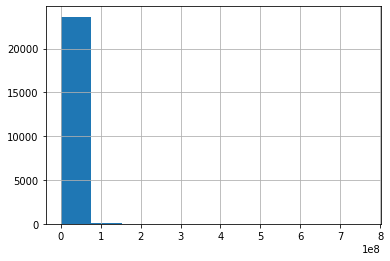

In [17]:
print(data['last_price'].describe()) #смотрим описание значений в столбце last_price
data['last_price'].hist() #строим гистограмму для столбца last_price

Максимум цены опять-таки выглядит запредельно высоким. А на гистограмме даже визуально не различаются объекты со стоимостью выше 20000000 руб. Минимальные значения будут дополнительно рассмотрены и отсеяны в рамках оценки цены за квадратный метр.

Построим новую гистограмму last_price, ограничив диапазон значений и увеличив число "корзин".

<AxesSubplot:>

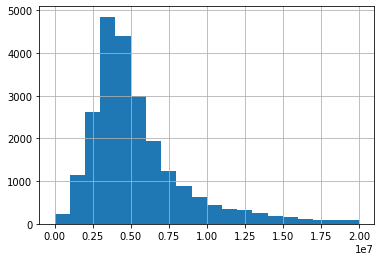

In [18]:
data['last_price'].hist(bins=20, range=(0, 20000000)) #строим гистограмму для столбца last_price по уточненным параметрам

Новая гистограмма last_price также выглядит правдоподобно и, что особенно важно, в целом напоминает по форме уточненную гистограмму total_area. Это подтверждает правильность выбранных диапазонов.

Применяется описание значений и построение первичной гистограммы для параметра rooms.

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


<AxesSubplot:>

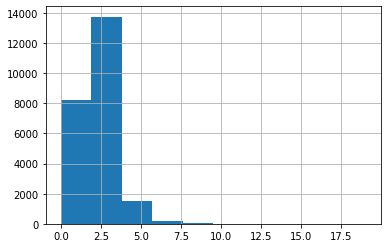

In [19]:
print(data['rooms'].describe()) #смотрим описание значений в столбце rooms
data['rooms'].hist() #строим гистограмму для столбца rooms

Снова наблюдается нереалистичное максимальное число (19) комнат и невозможное минимальное (0). Гистограмма указывает на несущественное число объектов больше чем с 8 комнатами.

Построим новую гистограмму rooms, ограничив диапазон значений и задав число "корзин" по числу комнат, чтобы избежать "дыр" в гистограмме.

<AxesSubplot:>

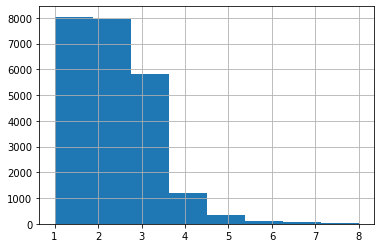

In [20]:
data['rooms'].hist(bins=8, range=(1, 8)) #строим гистограмму для столбца rooms по уточненным параметрам

Теперь статистика соответствует ожиданиям: 1, 2 и 3 комнаты - это превалирующие значения.

Применяется описание значений и построение первичной гистограммы для параметра ceiling_height.

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


<AxesSubplot:>

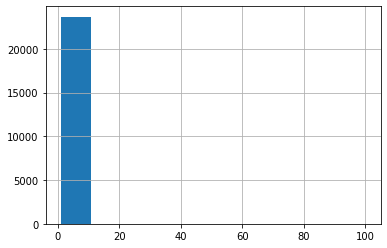

In [21]:
print(data['ceiling_height'].describe()) #смотрим описание значений в столбце ceiling_height
data['ceiling_height'].hist() #строим гистограмму для столбца ceiling_height

Нереальные минимумы и максимумы "загоняют" все данные в один столбец гистограммы.

Построим новую гистограмму ceiling_height, ограничив диапазон значений и ориентируясь на значения квартилей.

<AxesSubplot:>

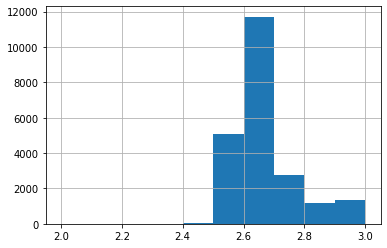

In [22]:
data['ceiling_height'].hist(range=(2, 3)) #строим гистограмму для столбца ceiling_height по уточненным параметрам

Новое распределение выглядит приемлемым.

Применяется описание значений и построение первичной гистограммы для параметра meter_price.

count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118349e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: meter_price, dtype: float64


<AxesSubplot:>

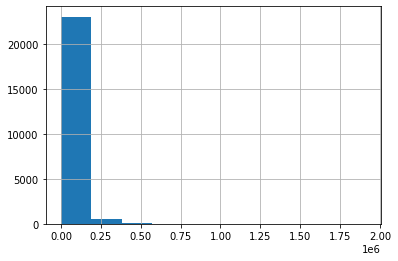

In [23]:
print(data['meter_price'].describe()) #смотрим описание значений в столбце meter_price
data['meter_price'].hist() #строим гистограмму для столбца meter_price

И снова, как и в случае last_price, отмечается крайне высокий максимум. Гистограмма показывает практически полное отсутствие объектов после отметки примерно в 350000 рублей за метр. Также вызывает вопросы минимальное значение, хотя в целом можно допустить весьма низкие (но не настолько) цены в отдельных случаях.

Построим новую гистограмму meter_price, ограничив диапазон значений и увеличив число "корзин".

<AxesSubplot:>

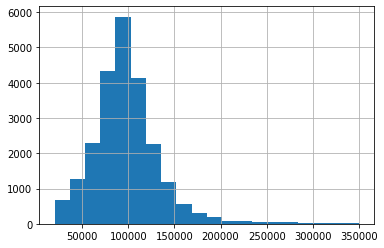

In [24]:
data['meter_price'].hist(bins=20, range=(20000, 350000)) #строим гистограмму для столбца meter_price по уточненным параметрам

Новое распределение достаточно близко по виду к общему распределению цены. На данном этапе принимаются выбранные значения параметров.

Далее более подробно изучаются данные в столбце days_exposition. Также применяется описание данных и построение гистограммы.

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


<AxesSubplot:>

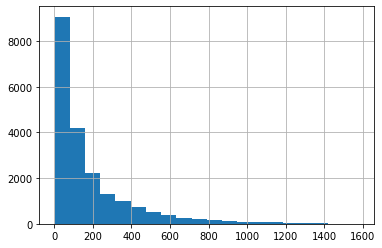

In [25]:
print(data['days_exposition'].describe()) #смотрим описание значений в столбце days_exposition
data['days_exposition'].hist(bins=20) #строим гистограмму для столбца days_exposition

Медианное значение days_exposition составляет 95 дней, а среднее - 180 дней. То есть продажа квартиры обычно занимает около 3-х месяцев.

Построим дополнительно диаграмму размаха для значений days_exposition.

<AxesSubplot:>

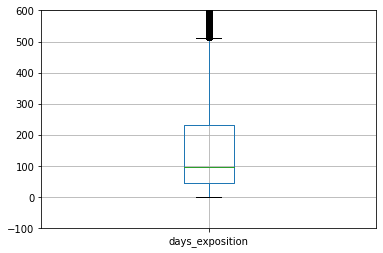

In [26]:
plt.pyplot.ylim(-100, 600) #задаем лимиты значений
data.boxplot('days_exposition') #строим диаграмму размаха для столбца days_exposition

Исходя из диаграммы, видно, что необычно долгие продажи проходят более 500 дней, а необычно быстрые - всего за несколько дней (хотя такое быстрое снятие объявления может быть связано с другими причинами).

Далее делается срез из общего датафрейма с учетом выбранных допустимых значений изучаемых параметров. 

In [27]:
data_normal = data.query('total_area >= 20 and total_area <= 250 and last_price <= 20000000 and rooms >=1 and rooms <= 8 and ceiling_height >= 2 and ceiling_height <= 3 and meter_price >= 20000 and meter_price <= 350000') #делаем срез по выбранным параметрам

print((1 - len(data_normal)/len(data))*100) #рассчитаем процент потерянных данных

9.920249799569604


Проводится проверка внесенных изменений.

In [28]:
data_normal.info() #смотрим сводку основной информации
data_normal.head() #смотрим как отображаются данные

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21348 non-null  int64         
 1   last_price            21348 non-null  float64       
 2   total_area            21348 non-null  float64       
 3   first_day_exposition  21348 non-null  datetime64[ns]
 4   rooms                 21348 non-null  int64         
 5   ceiling_height        21348 non-null  float64       
 6   floors_total          21267 non-null  float64       
 7   living_area           21348 non-null  float64       
 8   floor                 21348 non-null  int64         
 9   is_apartment          2483 non-null   object        
 10  studio                21348 non-null  bool          
 11  open_plan             21348 non-null  bool          
 12  kitchen_area          21348 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,exposition_weekday,exposition_month,exposition_year,floor_category,living_ratio,kitchen_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
5,10,2890000.0,30.4,2018-09-10,1,2.65,12.0,14.4,5,NaN,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,0.473684,0.299342
6,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,NaN,False,False,14.4,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,0.284182,0.386059


Количество строк сократилось чуть менее чем на 10% - допустимые потери, с учетом того, что были отсечены все явно редкие и выбивающиеся значения.

Далее для изучения влияния различных факторов на цену квартиры строится матрица корреляций.

In [29]:
data_normal.corr() #строим матрицу корреляции

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,exposition_weekday,exposition_month,exposition_year,living_ratio,kitchen_ratio
total_images,1.000000,0.158639,0.108256,0.090006,0.022208,0.024910,0.094438,0.038813,-0.016418,-0.007321,0.075750,0.049809,0.005757,-0.036347,0.007278,-0.006210,-0.020375,0.000489,-0.033298,0.134517,-0.008650,0.004828,0.147674,0.006849,-0.027224
last_price,0.158639,1.000000,0.768190,0.486400,0.347807,0.175494,0.652080,0.129593,-0.018624,-0.004943,0.594156,0.078924,-0.016330,-0.319960,0.131973,0.076848,0.158181,-0.075444,0.096867,0.639922,-0.009817,0.010174,-0.014376,0.006873,-0.100539
total_area,0.108256,0.768190,1.000000,0.788362,0.252436,0.007123,0.923631,0.002678,-0.028210,-0.004669,0.568241,0.068967,-0.006087,-0.146867,0.074214,0.025732,0.110964,-0.041439,0.126446,0.054674,-0.005296,0.011872,-0.066924,0.198930,-0.347846
rooms,0.090006,0.486400,0.788362,1.000000,0.050806,-0.193862,0.875175,-0.143228,-0.023933,-0.002621,0.191882,0.021464,-0.044813,-0.098874,0.063428,-0.032030,0.044562,-0.013533,0.089155,-0.141840,0.001864,0.001207,-0.037756,0.548655,-0.601974
ceiling_height,0.022208,0.347807,0.252436,0.050806,1.000000,0.129730,0.166745,0.083813,0.008074,0.003658,0.309655,0.042356,-0.039928,-0.177027,0.093286,0.000652,0.119208,-0.066196,0.058422,0.258971,-0.008567,0.002247,-0.061063,-0.146227,0.122554
floors_total,0.024910,0.175494,0.007123,-0.193862,0.129730,1.000000,-0.122464,0.671037,0.016167,0.007567,0.261614,0.155775,0.092862,-0.053044,-0.219464,0.080337,-0.093980,0.016888,-0.035398,0.320205,0.009187,0.015289,0.004119,-0.369544,0.343631
living_area,0.094438,0.652080,0.923631,0.875175,0.166745,-0.122464,1.000000,-0.088888,-0.018835,-0.001600,0.325934,0.033515,-0.033268,-0.135118,0.092023,-0.016267,0.088511,-0.021773,0.111914,-0.038875,-0.000102,0.002246,-0.055320,0.529539,-0.544556
floor,0.038813,0.129593,0.002678,-0.143228,0.083813,0.671037,-0.088888,1.000000,0.011101,0.002717,0.179733,0.156043,0.062316,-0.031925,-0.144720,0.061716,-0.058788,0.015121,-0.031149,0.234563,0.009772,0.018586,0.003061,-0.262687,0.240135
studio,-0.016418,-0.018624,-0.028210,-0.023933,0.008074,0.016167,-0.018835,0.011101,1.000000,-0.000381,-0.025926,0.015579,0.008336,-0.002780,-0.003446,-0.006094,0.001861,-0.002693,-0.011420,0.005056,-0.003830,-0.008504,-0.032369,0.028991,-0.004443
open_plan,-0.007321,-0.004943,-0.004669,-0.002621,0.003658,0.007567,-0.001600,0.002717,-0.000381,1.000000,-0.004889,0.006766,-0.006441,0.001129,-0.000993,-0.010421,0.000781,-0.004492,0.001669,-0.001479,-0.005377,-0.002713,-0.030565,0.006834,-0.003281


На первый взгляд, общая цена в первую очередь зависит от общей площади квартиры, что в общем-то логично. Но матрица достаточно громоздкая, удобнее будет работать с отдельными срезами данных.

Построим срез с параметрами rooms, total_area и city_centers_nearest. Помимо матрицы корреляций, используем матрицу диаграмм рассеивания.  

,last_price,rooms,total_area,city_centers_nearest,meter_price
last_price,1.000000,0.486400,0.768190,-0.319960,0.639922
rooms,0.486400,1.000000,0.788362,-0.098874,-0.141840
total_area,0.768190,0.788362,1.000000,-0.146867,0.054674
city_centers_nearest,-0.319960,-0.098874,-0.146867,1.000000,-0.398591
meter_price,0.639922,-0.141840,0.054674,-0.398591,1.000000


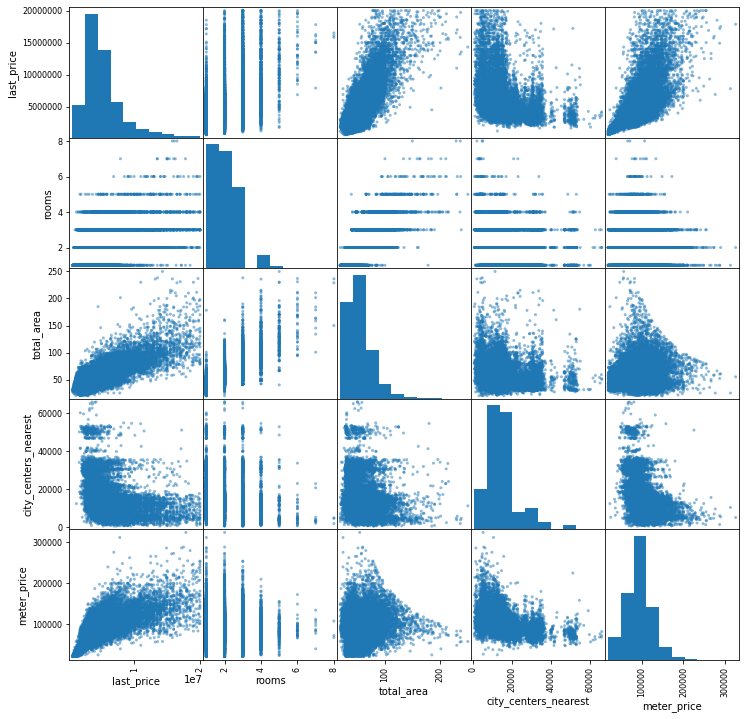

In [30]:
data_normal_1 = data_normal[['last_price', 'rooms', 'total_area', 'city_centers_nearest', 'meter_price']] #выбираем нужные столбцы
display(data_normal_1.corr()) #строим матрицу корреляции
pd.plotting.scatter_matrix(data_normal_1, figsize=(12, 12)) #строим матрицу диаграмм рассеивания
None

Итак, общая цена действительно в большей степени зависит от общей площади, что также подтверждается на диаграмме рассеивания. Вторым по значимости фактором является число комнат. При этом на цену за квадратный метр в первую очередь оказывает влияние удаленность от центра (хоть и гораздо меньшее, чем в случае общей цены и площади), что в целом также выглядит разумно. В то же время на диаграммах рассеивания видна некоторая "ступенчатость" в зависимости цен от расстояния до центра - это указывает на то, что можно выделить некий "истинный" центр, где квартиры ценятся выше за счет принадлежности к данной зоне.

Для рассмотрения связи цены с категорией этажа не подойдет корреляция, так как категория в этом случае не является количественным параметром. В связи с этим для наглядности будет использована столбчатая диаграмма. 

<AxesSubplot:xlabel='floor_category'>

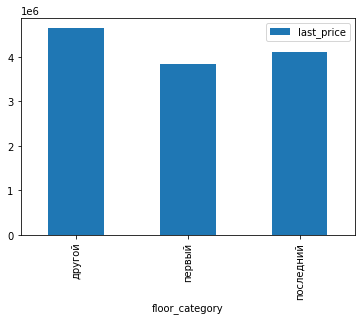

In [32]:
data_normal.pivot_table(index='floor_category', values='last_price', aggfunc='median').plot.bar() #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по категории этажа

Как можно было ожидать, меньше всего ценятся квартиры на первом этаже, хотя и последний этаж оказывается менее предпочтительным, чем другие варианты. Впрочем, из исходной матрицы корреляций следует что зависимость между конкретным номером этажа и общей ценой невелика и чуть больше данный фактор влияет на стоимость квадратного метра.

Также построим столбчатые диаграммы по параметрам exposition_weekday, exposition_month, exposition_year.

<AxesSubplot:xlabel='exposition_weekday'>

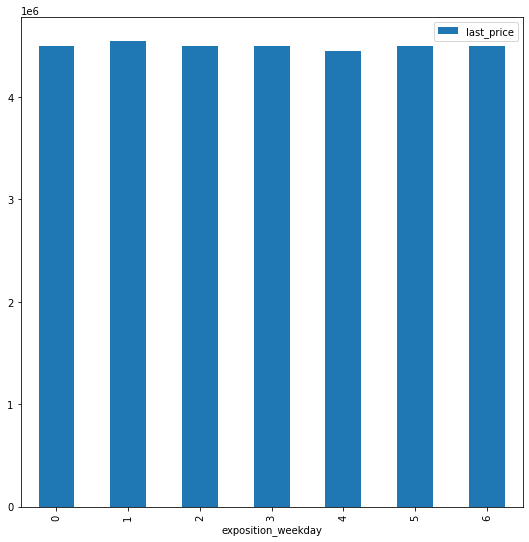

In [33]:
data_normal.pivot_table(index='exposition_weekday', values='last_price', aggfunc='median').plot.bar(figsize=(9, 9)) #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по дню недели

Связь с днем недели наблюдается слабая. Цена продажи чуть выше по вторникам и чуть ниже по пятницам, хотя вряд ли можно говорить о причинно-следственной связи в этом случае.

<AxesSubplot:xlabel='exposition_month'>

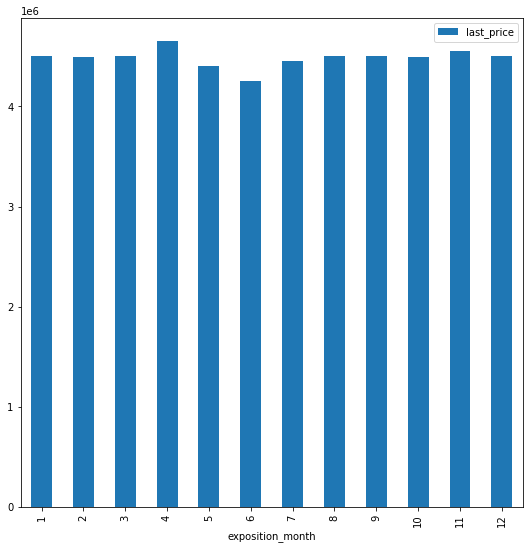

In [34]:
data_normal.pivot_table(index='exposition_month', values='last_price', aggfunc='median').plot.bar(figsize=(9, 9)) #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по месяцу

С конца весны до середины лета (май-июль) наблюдается снижение цен, которое может быть связано с общим спадом деловой активности в этот период (отпуска, завершение учебы и т.д.). Но вот до этого момента (в апреле), наблюдается локальный скачок цен вверх.

<AxesSubplot:xlabel='exposition_year'>

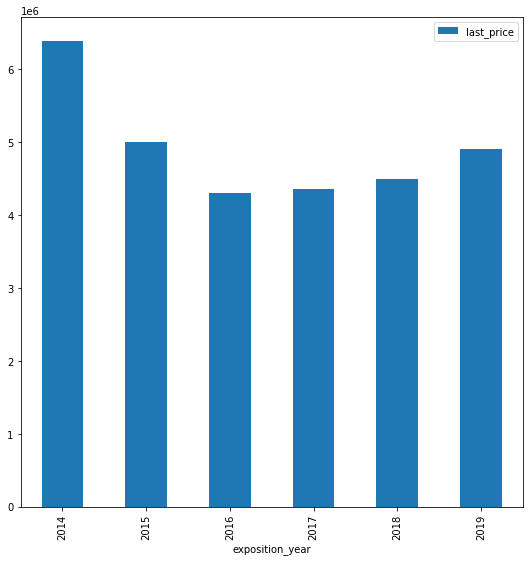

In [35]:
data_normal.pivot_table(index='exposition_year', values='last_price', aggfunc='median').plot.bar(figsize=(9, 9)) #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по году

Цены по годам показывают существенное снижение с 2014 по 2016 год, после чего начинается медленный рост.

Далее будут рассмотрены ценовые параметры в разбивке по населенным пунктам, представленным в выборке.

Сначала выделим 10 населенных пунктов с наибольшим количество объявлений о продаже квартир и посмотрим на среднюю цену жилья в них.

,count,mean
locality_name,,
Санкт-Петербург,13770,107742.106970
посёлок Мурино,494,85071.279587
посёлок Шушары,435,78382.648164
Всеволожск,387,67085.222447
Пушкин,344,101441.816565
Колпино,327,75375.283038
посёлок Парголово,323,90289.778393
Гатчина,298,69202.246114
деревня Кудрово,283,92297.218847


82476.52113126077


<AxesSubplot:xlabel='locality_name'>

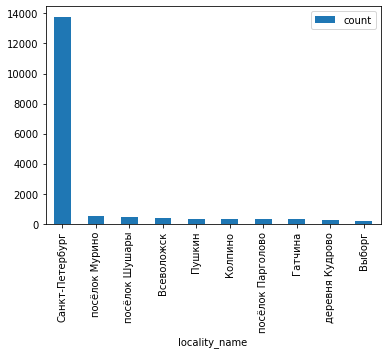

In [36]:
data_local = data_normal.pivot_table(index='locality_name', values='meter_price', aggfunc=['count', 'mean']) #строим сводную таблицу с группипровкой средней цены квадратного метра и числа объявлений по названию населенного пункта

data_local.columns = ['count', 'mean'] #для удобства переименуем названия столбцов
 
data_local = data_local.sort_values('count', ascending=False) #отсортируем данные по убыванию числа объявлений

display(data_local.head(10)) #выведем первые 10 населенных пунктов
print(data_local.head(10)['mean'].mean()) #рассчитаем среднюю цену за метр в этих населенных пунктах
data_local.head(10).plot.bar(y='count') #построим столбчатую диаграмму

Ожидаемо, больше всего объявлений приходится на Санкт-Петербург, но возможно, что в среднем самая дорогая недвижимость находится не там, проверим это. 

,count,mean
locality_name,,
посёлок Лисий Нос,2,121616.221359
Санкт-Петербург,13770,107742.106970
Зеленогорск,23,106043.631251
Пушкин,344,101441.816565
Сестрорецк,176,100417.430837
Кудрово,168,99958.155945
деревня Мистолово,11,98549.976709
посёлок Левашово,1,96997.690531
Мурино,33,92479.984920


<AxesSubplot:xlabel='locality_name'>

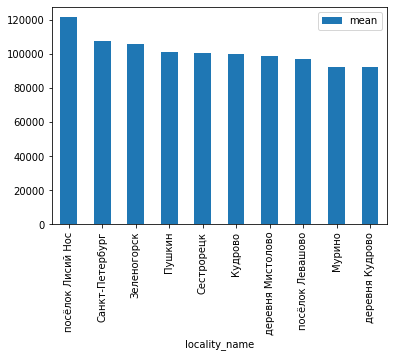

In [37]:
data_local = data_local.sort_values('mean', ascending=False) #отсортируем данные по убыванию средней цены квадратного метра

display(data_local.head(10)) #выведем первые 10 населенных пунктов
data_local.head(10).plot.bar(y='mean') #построим столбчатую диаграмму

Как мы видим, есть поселок Лисий Нос с небольшим числом объявлений, но высокой средней ценой - вероятно, речь идет об элитной недвижимости.

Посмотрим также на населенные пункты с самыми низкими средними ценами на квадратный метр жилья.

,count,mean
locality_name,,
посёлок Алексеевка,1,22222.222222
поселок Торковичи,2,22089.028049
поселок Оредеж,1,21995.464853
Пикалёво,5,21493.959126
Бокситогорск,2,21198.851573
деревня Тихковицы,1,21126.760563
посёлок Плоское,1,20912.547529
деревня Кисельня,1,20909.090909
поселок городского типа Никольский,2,20847.821048


<AxesSubplot:xlabel='locality_name'>

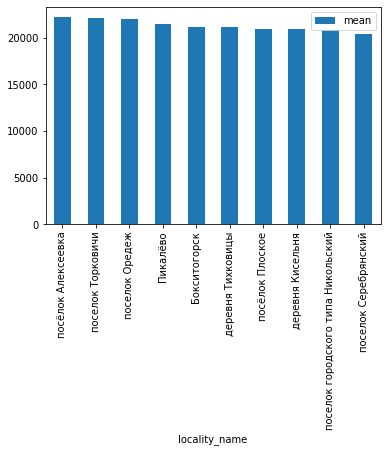

In [38]:
display(data_local.tail(10)) #выведем последние 10 населенных пунктов
data_local.tail(10).plot.bar(y='mean') #построим столбчатую диаграмму

Поселкам с дешевой недвижимостью также свойственно небольшое количество объявлений со схожей стоимостью квадратного метра (у нижнего края распределения).

Теперь вернемся к вопросу выделения "центра" города для анализа стоимости жилья  в данной зоне. Для этого построим отдельный график зависимости цены квартир от расстояния до центра непосредственно в Санкт-Петербурге.

<AxesSubplot:xlabel='km_to_center'>

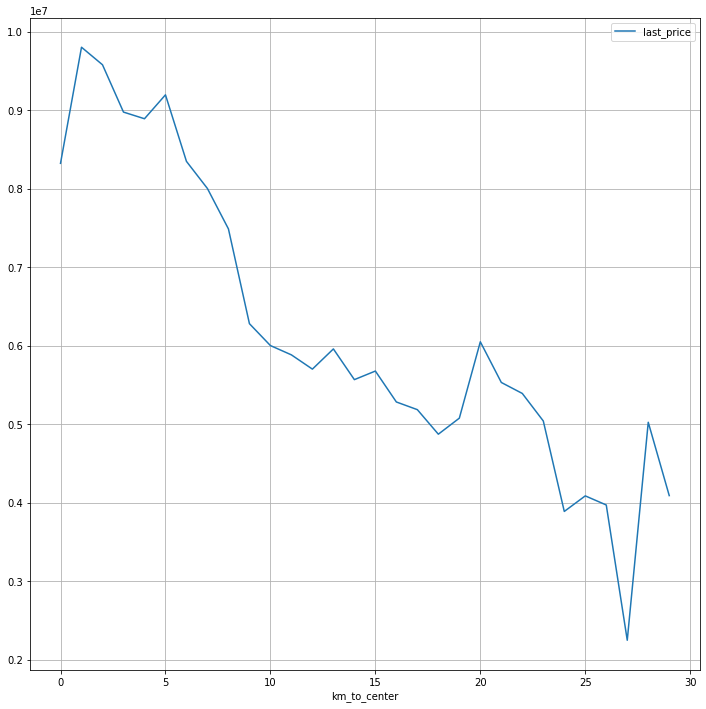

In [39]:
data_spb = pd.DataFrame(data_normal.query('locality_name == "Санкт-Петербург"')) #выделяем сегмент квартир в Санкт-Петербурге

data_spb['km_to_center'] = data_spb['city_centers_nearest']/1000 #добавляем столбец с расстоянием до центра города в километрах
data_spb['km_to_center'] = data_spb['km_to_center'].round() #округляем значения в новом столбце

data_spb.pivot_table(index='km_to_center', values='last_price').plot(grid=True, figsize=(12, 12)) #строим точечную диаграмму на основе сводной таблицы с группировкой общей цены квартиры по расстоянию от центра

Также построим отдельный график зависимости цены квадратного метра от расстояния до центра в Санкт-Петербурге.

<AxesSubplot:xlabel='km_to_center'>

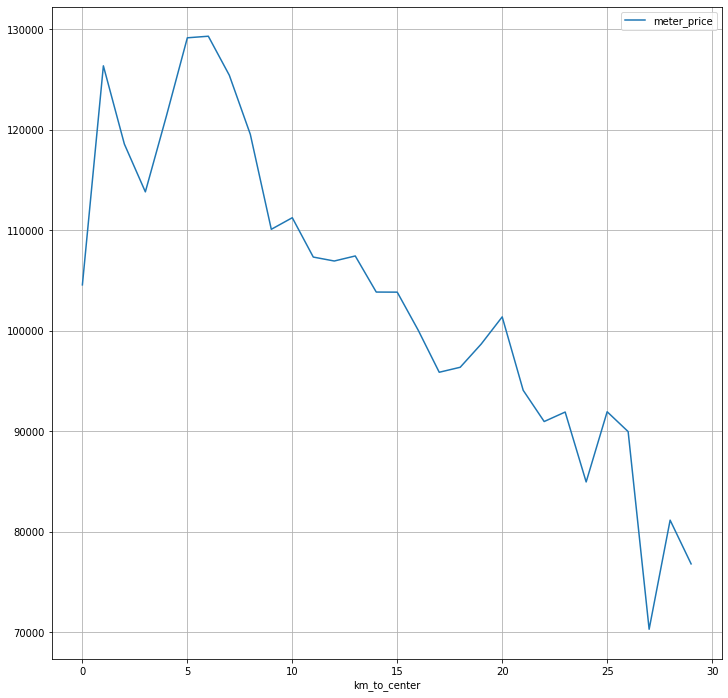

In [40]:
data_spb.pivot_table(index='km_to_center', values='meter_price').plot(grid=True, figsize=(12, 12)) #строим точечную диаграмму на основе сводной таблицы с группировкой цены квадратного метра по расстоянию от центра

В обоих случаях графики начинают резко возрастать при приближении к центру менее чем на 9 км. Этот радиус и будет считаться "центральной зоной" с точки зрения продажи недвижимости в городе.

In [41]:
data_central = data_normal.query('city_centers_nearest <= 9000') #выделяем сегмент квартир в центральной зоне

Применяется описание значений и построение гистограммы для параметра total_area в центре города.

count    2808.000000
mean       70.061670
std        29.841217
min        20.000000
25%        46.750000
50%        65.000000
75%        85.500000
max       238.260000
Name: total_area, dtype: float64


<AxesSubplot:>

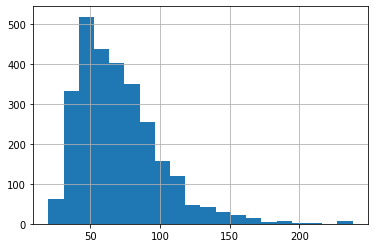

In [42]:
print(data_central['total_area'].describe()) #смотрим описание значений в столбце total_area
data_central['total_area'].hist(bins=20) #строим гистограмму для столбца total_area

Распределение по площади в центре спадает не так быстро, как в целом по всей базе, и даже имеет небольшой второй "пик" для значений в 50-75 квадратных метров. Посмотрим, будет ли этот факт соотносится с дальнейшей статистикой. 

Применяется описание значений и построение гистограммы для параметра last_price в центре города.

count    2.808000e+03
mean     8.409170e+06
std      3.789452e+06
min      2.100000e+06
25%      5.600000e+06
50%      7.500000e+06
75%      1.050000e+07
max      2.000000e+07
Name: last_price, dtype: float64


<AxesSubplot:>

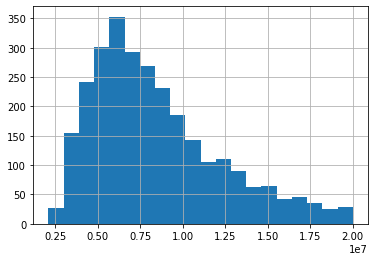

In [43]:
print(data_central['last_price'].describe()) #смотрим описание значений в столбце last_price
data_central['last_price'].hist(bins=20) #строим гистограмму для столбца last_price

Ценовое распределение также гораздо более "пологое", что вполне объяснимо - квартиры в центре ближе друг к другу по ценовой категории.

Применяется описание значений и построение гистограммы для параметра rooms в центре города.

count    2808.000000
mean        2.376425
std         1.089366
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: rooms, dtype: float64


<AxesSubplot:>

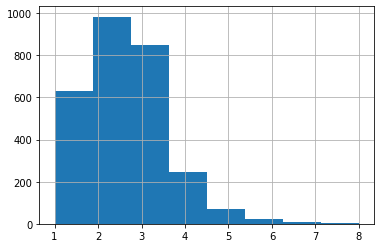

In [44]:
print(data_central['rooms'].describe()) #смотрим описание значений в столбце rooms
data_central['rooms'].hist(bins=8) #строим гистограмму для столбца rooms

В отличие от всей базы, 2-х и 3-х комнатных квартир в центре больше, чем "однушек". Это в достаточной степени соответствует логике полученного распределения квартирных площадей.

Применяется описание значений и построение гистограммы для параметра ceiling_height в центре города.

count    2808.00000
mean        2.72412
std         0.14896
min         2.00000
25%         2.65000
50%         2.65000
75%         2.80000
max         3.00000
Name: ceiling_height, dtype: float64


<AxesSubplot:>

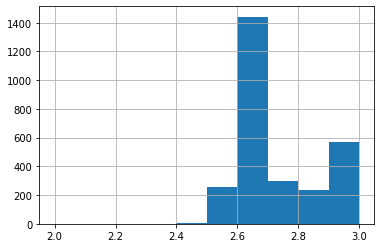

In [45]:
print(data_central['ceiling_height'].describe()) #смотрим описание значений в столбце ceiling_height
data_central['ceiling_height'].hist() #строим гистограмму для столбца ceiling_height

В центре явно выделяется группа квартир с высокими потолками.

Применяется описание значений и построение гистограммы для параметра meter_price в центре города.

count      2808.000000
mean     122682.664290
std       34080.041138
min       26250.000000
25%       98005.952381
50%      117118.518862
75%      140942.754271
max      324727.272727
Name: meter_price, dtype: float64


<AxesSubplot:>

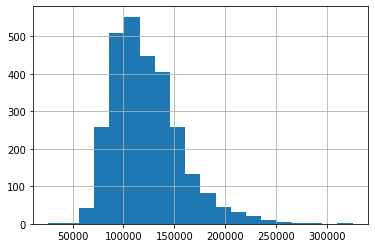

In [46]:
print(data_central['meter_price'].describe()) #смотрим описание значений в столбце meter_price
data_central['meter_price'].hist(bins=20) #строим гистограмму для столбца meter_price

Высокая частота наблюдается у достаточно большого "серединного" набора значений, что опять же подтверждает логику о том, что большинство квартир находятся в "центральном" стоимостном классе.

Построим матрицу корреляций различных квартирных параметров и цен в центральной части города.

In [47]:
data_central.corr() #строим матрицу корреляции

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,exposition_weekday,exposition_month,exposition_year,living_ratio,kitchen_ratio
total_images,1.000000,0.109936,0.019157,0.030649,0.055449,-0.021805,0.016350,0.011369,-0.018715,0.011379,0.048913,0.013393,-0.018015,0.004368,0.034548,-0.014906,0.001542,-0.010685,-0.050516,0.145424,0.023404,0.001209,0.155661,-0.000568,0.021341
last_price,0.109936,1.000000,0.761607,0.511494,0.182858,0.126502,0.640316,0.144056,-0.019474,-0.014493,0.572390,0.120613,-0.052186,-0.214685,0.076223,0.081395,0.103899,-0.028159,0.139306,0.453545,-0.011976,0.002580,-0.026740,0.017579,-0.097467
total_area,0.019157,0.761607,1.000000,0.808618,0.158020,-0.021896,0.925984,0.024047,-0.022813,-0.003518,0.524431,-0.018831,-0.101597,-0.259159,0.079292,0.009921,0.051392,-0.007056,0.161330,-0.183138,0.000162,0.004723,-0.101525,0.220630,-0.334134
rooms,0.030649,0.511494,0.808618,1.000000,0.132020,-0.208694,0.869081,-0.102449,-0.023853,0.010806,0.220765,-0.106035,-0.119714,-0.253312,0.099082,-0.073820,0.011614,-0.017739,0.108056,-0.328337,-0.002566,-0.006092,-0.068744,0.498846,-0.519454
ceiling_height,0.055449,0.182858,0.158020,0.132020,1.000000,-0.118794,0.137102,-0.068852,0.009616,0.034963,0.099572,0.017828,-0.058373,-0.126511,0.052079,-0.004396,0.038541,0.004120,0.063965,0.074029,-0.027029,-0.012908,0.043958,0.007725,-0.039317
floors_total,-0.021805,0.126502,-0.021896,-0.208694,-0.118794,1.000000,-0.145157,0.655551,0.006817,-0.012752,0.181294,0.338495,0.150261,0.352349,-0.219657,0.084810,-0.023744,0.033443,0.005779,0.235750,0.012836,0.023148,-0.007769,-0.344089,0.250040
living_area,0.016350,0.640316,0.925984,0.869081,0.137102,-0.145157,1.000000,-0.052999,-0.018029,0.006530,0.289709,-0.076201,-0.122673,-0.259402,0.104133,-0.048206,0.032689,-0.000683,0.133621,-0.264588,0.000560,-0.008237,-0.085438,0.538292,-0.516831
floor,0.011369,0.144056,0.024047,-0.102449,-0.068852,0.655551,-0.052999,1.000000,0.029479,-0.014414,0.133047,0.271381,0.079777,0.227229,-0.155719,0.068984,-0.028828,0.030450,0.002170,0.195969,0.016717,0.014140,-0.009157,-0.192795,0.128280
studio,-0.018715,-0.019474,-0.022813,-0.023853,0.009616,0.006817,-0.018029,0.029479,1.000000,-0.000356,-0.019196,0.036343,-0.005633,-0.003104,-0.018869,NaN,-0.003332,-0.004876,-0.012278,0.005357,-0.027882,-0.013581,-0.020425,0.007854,-0.001444
open_plan,0.011379,-0.014493,-0.003518,0.010806,0.034963,-0.012752,0.006530,-0.014414,-0.000356,1.000000,-0.002009,-0.008963,-0.016276,-0.027449,0.024703,-0.019884,0.014661,-0.024511,0.000776,-0.020723,0.015511,0.024785,-0.037565,0.029838,-0.001444


Основными факторами влияния остаются общая площадь и количество комнат. Но рассмотрим отдельные данные более подробно.

Построим срез с параметрами rooms, total_area и city_centers_nearest для центральной части города. Помимо матрицы корреляций, используем матрицу диаграмм рассеивания.

,last_price,rooms,total_area,city_centers_nearest,meter_price
last_price,1.000000,0.511494,0.761607,-0.214685,0.453545
rooms,0.511494,1.000000,0.808618,-0.253312,-0.328337
total_area,0.761607,0.808618,1.000000,-0.259159,-0.183138
city_centers_nearest,-0.214685,-0.253312,-0.259159,1.000000,-0.027469
meter_price,0.453545,-0.328337,-0.183138,-0.027469,1.000000


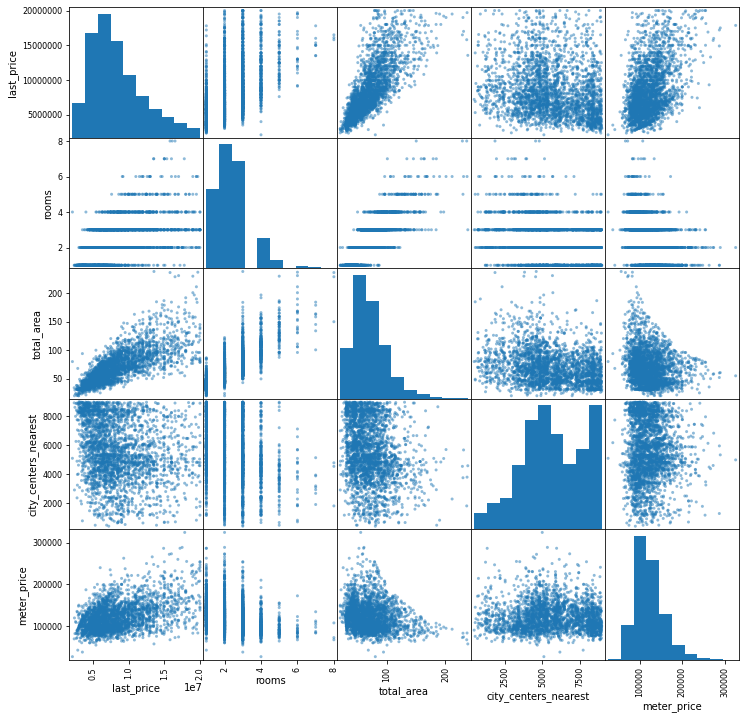

In [48]:
data_central_1 = data_central[['last_price', 'rooms', 'total_area', 'city_centers_nearest', 'meter_price']] #выбираем нужные столбцы
display(data_central_1.corr()) #строим матрицу корреляции
pd.plotting.scatter_matrix(data_central_1, figsize=(12, 12)) #строим матрицу диаграмм рассеивания
None

Влияние числа комнат на общую стоимость стало немного выше (коэффициент корреляции "перевалил" через 0.5). А расстояние до центра, как ни странно, показывает отрицательную связь, хотя скорее всего это просто отражает отсутствие явной связи, что особенно четко выражено по степени влияния расстояния на цену квадратного метра, близкой к нулю.

Построим столбчатую диаграмму медианной цены по категории этажа для центральной части города.

<AxesSubplot:xlabel='floor_category'>

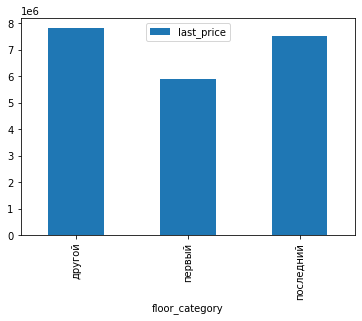

In [49]:
data_central.pivot_table(index='floor_category', values='last_price', aggfunc='median').plot.bar() #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по категории этажа

Как можно увидеть, первый этаж в этом случае гораздо сильнее проигрывает другим категориям - видимо, ввиду плотности застройки и непосредственного прилегания домов к тротуарам и проезжим частям. Последний же этаж котируется практически также, как и остальные - вероятно, из-за небольшой высотности, либо элитности расположения "выше всех в центре".

Также построим столбчатые диаграммы по параметрам exposition_weekday, exposition_month, exposition_year для центральной части города.

<AxesSubplot:xlabel='exposition_weekday'>

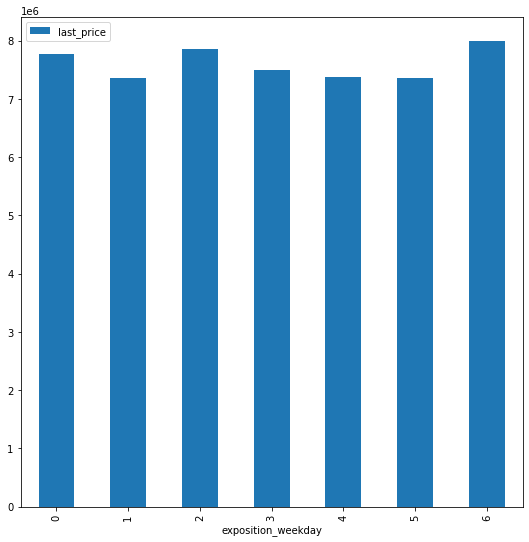

In [50]:
data_central.pivot_table(index='exposition_weekday', values='last_price', aggfunc='median').plot.bar(figsize=(9, 9)) #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по дню недели

В центре заметное увеличение цены продажи квартир, в отличие от общей статистики, наблюдается в среду и воскресенье.

<AxesSubplot:xlabel='exposition_month'>

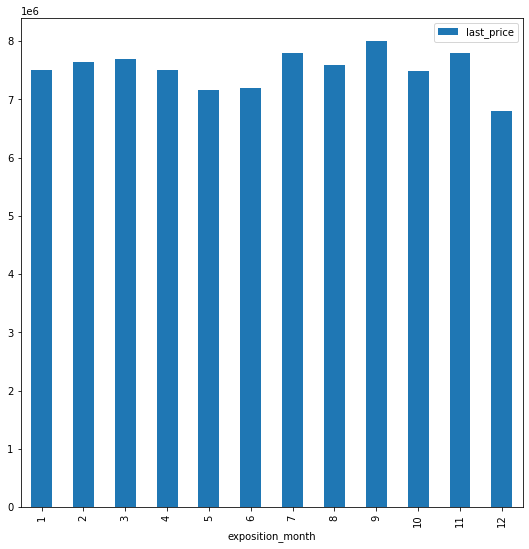

In [51]:
data_central.pivot_table(index='exposition_month', values='last_price', aggfunc='median').plot.bar(figsize=(9, 9)) #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по месяцу

В центре также наблюдается плавный спад цен в конце весны и начале лета (май-июнь), однако уже в июле цена "выстреливает" вверх, и затем делает то же самое с шагом в два месяца - в сентябре и ноябре. Зато показатели по декабрю очень сильно снижаются относительно всех остальных значений.

<AxesSubplot:xlabel='exposition_year'>

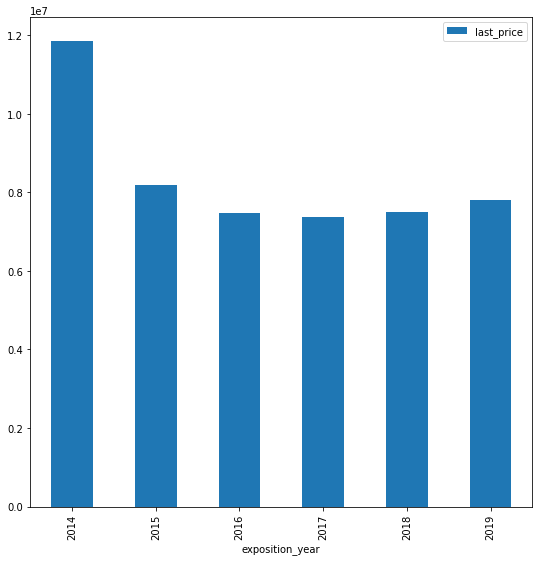

In [52]:
data_central.pivot_table(index='exposition_year', values='last_price', aggfunc='median').plot.bar(figsize=(9, 9)) #строим столбчатую диаграмму на основе сводной таблицы с группировкой медианных цен по году

По сравнению с общими данными, разбивка по годам для центра показывает более резкое падение цен в первые пару лет и гораздо более слабое восстановление в последующие годы. Вероятно, кризис значительнее отразился на дорогой недвижимости.

В целом данные по центру в привязке ко времени показывают более выраженные особенности и взлеты/падения цен относительно различных периодов.

### Вывод

В ходе анализа были подробнее рассмотрены диапазоны ряда ключевых параметров (таких как цена, площадь, количество комнат, высота потолков). По итогам из базы данных были удалены слишком большие и слишком малые значения этих параметров, выбивающиеся из общего распределения. В дальнейшем такие значения могут служить для оценки "нормальности" новых объявлений о продаже квартир. Оставшиеся в выборке данные предоставили достаточной объем сведений для получения основных выводов о влиянии различных факторов на цену недвижимости. В результате можно сказать, что основным фактором, влияющим на цену квартир, является их общая площадь, на втором месте по значимости - число комнат. В качестве дополнительных, но менее значимых факторов можно назвать расстояние до центра и этажность. Также была выделена группа квартир в центральной части города, которая в целом повторяет общую логику зависимости цены от жилых характеристик, но имеет ряд особенностей - например, в части числа комнат (меньшая доля однокомнатных квартир) или влияния этажа на цену (последний этаж ценится существенно сильнее первого).

## Общий вывод

Был проведен анализ данных о продаже недвижимости в Санкт-Петербурге и соседних населенных пунктах, включающий несколько основных блоков работ:
1. Предобработка данных и дополнительные расчеты:
- в ходе оценки данных были выявлены пропуски, связанные как с ручным вводом, так и с автоматическим заполнением картографической информации;
- были заполнены пропуски в параметрах высоты потолков и жилой/кухонной площади - на базе медианных значений, а также в количестве балконов - пропуски в этом случае приравнивались к нулю;
- остальные пропуски на данном этапе не представляется заполнить логичным образом без более подробного изучения данных гео-информационной системы;
- был изменен тип значений в количестве балконов - на целочисленный, а в дне публикации объявления - на формат даты;
- дополнительно были рассчитаны и добавлены в таблицу следующие параметры - цена за квадратный метр, отношение жилой площади к общей площади, отношение площади кухни к общей площади, день недели/месяц/год публикации объявления, категория этажа (первый, последний или другой).

2. Исследовательский анализ данных:
- были изучены основные характеристики квартир и определены значения соответствующих параметров, выбивающиеся из общего распределения;
- за "нормальные" значения в рамках данного исследования были приняты следующие величины:
    * общая площадь квартиры - от 20 до 250 квадратных метров;
    * общая стоимость квартиры - до 20 000 000 рублей;
    * количество комнат - от 1 до 8;
    * высота потолков - от 2.4 до 3.0 метров;
    * цена за квадратный метр - от 20 000 до 350 000 рублей;
- при этом обычно продажа квартиры занимает 95 дней, самые долгие продажи могут занимать около полутора лет, а самые быстрые, напротив, несколько дней; 
- исходная база данных была отфильтрована в соответствии с указанными диапазонами значений, при этом было отсеяно менее 10% данных;
- оставшиеся данные были использованы для выявления зависимости цены недвижимости от различных факторов; 
- основными факторами, влияющими на стоимость квартиры, являются:
   * общая площадь - коэффициент корреляции = 0.77;
   * количество комнат - коэффициент корреляции = 0.49;
- дополнительными факторами, влияющими в большей степени на цену квадратного метра, можно считать:
   * расстояние до центра - коэффициент корреляции = -0.40;
   * этажность - коэффициент корреляции = 0.32;
- также было выявлено, что квартиры на первых этажах продаются в среднем дешевле, чем квартиры на последних, а те, в свою очередь, ценятся меньше всех прочих вариантов;
- кроме этого, была выявлена сезонность в стоимости продажи квартир - конец весны и первая половина лета (май - июль) являются периодом понижения цены продажи жилья;
- более того, рынок в целом значительно упал в 2014-2016 годах и с того момента вёл медленное восстановление;
- наибольшее количество объявлений о продаже жилья приходится на Санкт-Петербург - 13 770 штук, но при этом есть поселки (в частности, Лисий Нос), где средняя цена за метр жилья выше, чем в городе - 121 616 против 107 742 рублей;
- была определена часть города, которую можно считать "центральной" с точки зрения ценового класса квартир - это зона примерно в 9 км радиусом вокруг центральной точки города;
- отдельно были изучены факторы, влияющие на стоимость квартир в центре, в целом они соответствуют общим зависимостям, но есть и ряд особенностей, таких как:
   * квартиры в центре характеризуются большей площадью за счет числа комнат (чаще 2 и 3, а не 1) и высотой потолков;
   * внутри центральной зоны приближение к непосредственному центру города уже не оказывает значимого влияния на стоимость квартир;
   * квартиры на первых этажах в центре ценятся заметно меньше, зато на последних этажах стоимость практически не отличается от других вариантов;
   * сезонные всплески, а также общеэкономические годовые провалы в случае центральных квартир носят более выраженный характер.
   
3. Дополнительные выводы и предположения:
- в ходе анализа появился ряд промежуточных выводов и гипотез, которые могут быть рассмотрены в дальнейшем:
   * в используемой гео-информационной системе, вероятно, отсутствуют какие-то территориальные зоны - хорошо бы вести учет таких фактов, чтобы различать отсутствующие и нулевые значения;
   * снятие публикаций может происходить не только при продаже квартиры - такие случаи тоже желательно выделять в отдельные кейсы;
   * требуется уточнить каким образом заполняются данные об отнесении квартиры к категории апартаментов.